In [1]:
import numpy as np
import os
import skimage
import skimage.io

import utils
reload(utils)
from utils import *

%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (10.0, 15.0)

## Непосредственно код отрисовки

In [11]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt


def bbox_height(bbox):
    return bbox[3] - bbox[1]

def bbox_width(bbox):
    return bbox[2] - bbox[0]


def plot_image_estimated_al_maqrizi_probability2(
    image_color,
    patch_bbox_p_list,
    cmap=plt.get_cmap('OrRd'),
    font = {
        'family': 'Times New Roman',
        'weight': 'normal',
        'size': 18
    },
    nbins=40
):
    image_p = np.zeros((image_color.shape[0], image_color.shape[1], 3))
    for bbox, p in patch_bbox_p_list:
        col = cmap(p)
        for i in range(3):
            image_p[bbox[0]:bbox[2], bbox[1]:bbox[3], i] = col[i] 
            
    bbox_list = [bp[0] for bp in patch_bbox_p_list]
    sigma = np.sqrt(np.mean([np.median(map(bbox_height, bbox_list)), np.median(map(bbox_width, bbox_list))]))
    image_p = skimage.filters.gaussian_filter(image_p, sigma=sigma, multichannel=True)
    
    # resulting image.
    image_color = skimage.exposure.equalize_hist(image_color)
    res_im = (image_color * 0.6 + image_p * 0.4)
            
    probabilities = np.array([p for bbox, p in patch_bbox_p_list])
    
    # plotting
    
    matplotlib.rc('font', **font)

    ax1 = plt.subplot2grid((100, 1), (0, 0), rowspan=70)
    ax2 = plt.subplot2grid((100, 1), (72, 0), rowspan=4)
    ax3 = plt.subplot2grid((100, 1), (79, 0), rowspan=20)

    # plot image itself
    ax1.set_title(
        'Estimated Al-Maqrizi autorship probability' 
        + '\n Minimum: {0:.2}, Maximum: {1:.2}, Average: {2:.2}'.format(
            probabilities.min(), probabilities.max(), probabilities.mean()
    ))
    ax1.tick_params(axis='x', which='both', labelbottom='off')
    ax1.tick_params(axis='y', which='both', labelleft='off')
    ax1.imshow(res_im)
    
    # plot color map
    cb1 = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, orientation='horizontal', ticks=[0, 1])

    # plot probabilities histogram
    n, bins, patches = ax3.hist(probabilities, nbins, normed=0, color='green', range=[0, 1])
    bin_centers = 0.5 * (bins[:-1] + bins[1:])

    ## scale values to interval [0,1]
    col = bin_centers - min(bin_centers)
    col /= max(col)
    
    ## setting bin color
    for c, p in zip(col, patches):
        plt.setp(p, 'facecolor', cmap(c))

    ax3.set_yticks([0, 100])
    ax3.set_xticks([0, 1])

    plt.show()



## Пример на данных присланных Баденом

### Подготовка

In [3]:
import pickle
    
with open('./pickles/model_bw_svm.pickle', 'r') as f:
    model = pickle.load(f)

In [4]:
X_preprocess_foo = lambda X: sklearn.preprocessing.StandardScaler().fit_transform(X)
output_binary=True

In [5]:
def process_image(image_file):
    image_color = skimage.io.imread(image_file, as_grey=False)

    print '---------------------------------------------------------------------------------------------'
    print 'Image file: "{}"'.format(image_file.split('/')[-1])

    # extract patches with their bounding boxes
    bbox_patch_list = list(extract_patches(
        input_file=image_file,
        output_images_height=20,
        output_images_width=20,
        regions_filter=RegionsFilter(),
        region_resizer=MultiplyLowerThanMedianRegionResizer(),
        output_binary=output_binary,
        return_bbox=True
    ))
    bbox_list = [bp[0] for bp in bbox_patch_list]
    patch_list = [bp[1] for bp in bbox_patch_list]

    # get patches al-maqrizi authorship probability prediction
    X_test = [image_to_vector(patch) for patch in patch_list]
    X_test = X_preprocess_foo(X_test)
    y_test_pred_p = model.predict_proba(X_test)[:,1]
    probabilities = y_test_pred_p

    plot_image_estimated_al_maqrizi_probability2(
        image_color=image_color, 
        patch_bbox_p_list=zip(bbox_list, probabilities),
    #     cmap=plt.get_cmap('Blues')
    )

In [6]:
bauden_images_dir = '/home/obus/study/candidate/arabic/al_maqrizi/data/bauden_test'

os.listdir(bauden_images_dir)

['9b.jpg',
 'Ms-orient-A-01771_057.jpg',
 'YENI CAMI       887-_00094.JPG',
 'DSCN1532.JPG',
 'S Ali Pasa 1847 011.jpg',
 'MURAD MOLLA     575-_00055.JPG']

### Применение

---------------------------------------------------------------------------------------------
Image file: "9b.jpg"
extracted regions: 1479
filtered regions: 441


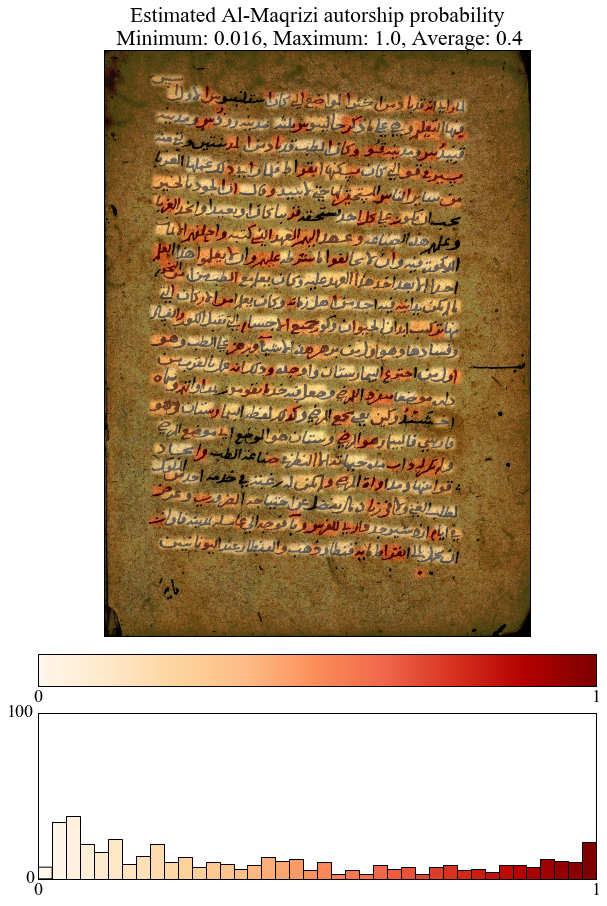

---------------------------------------------------------------------------------------------
Image file: "Ms-orient-A-01771_057.jpg"
extracted regions: 2994
filtered regions: 668


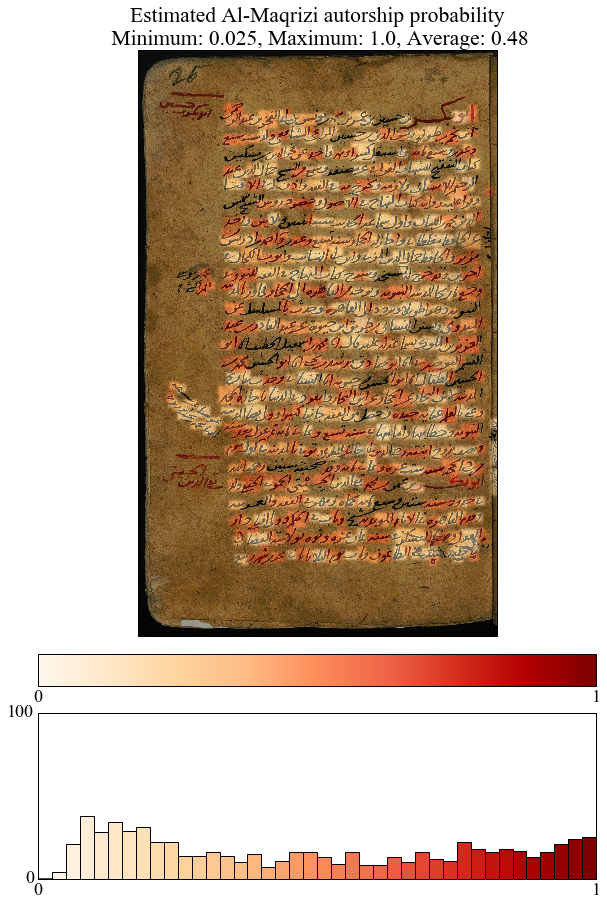

---------------------------------------------------------------------------------------------
Image file: "YENI CAMI       887-_00094.JPG"
extracted regions: 4004
filtered regions: 1278


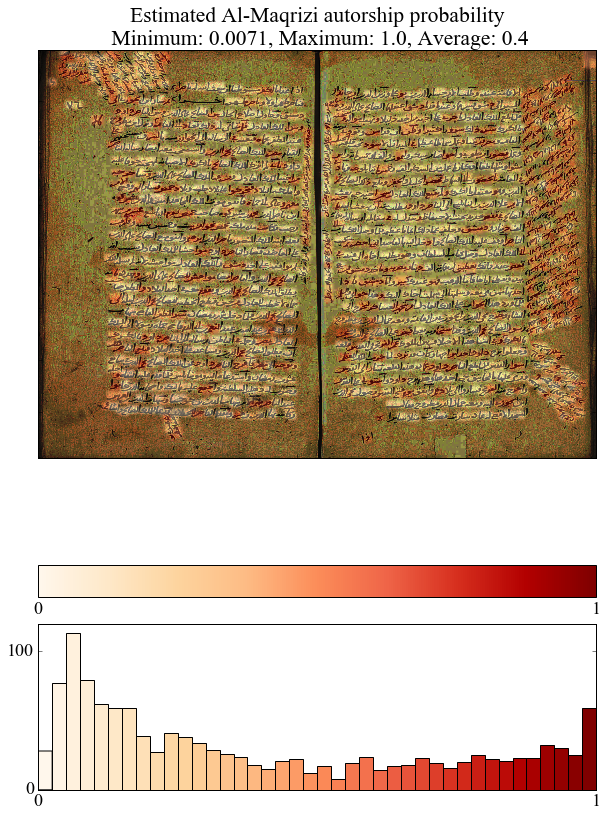

---------------------------------------------------------------------------------------------
Image file: "DSCN1532.JPG"
extracted regions: 2106
filtered regions: 499


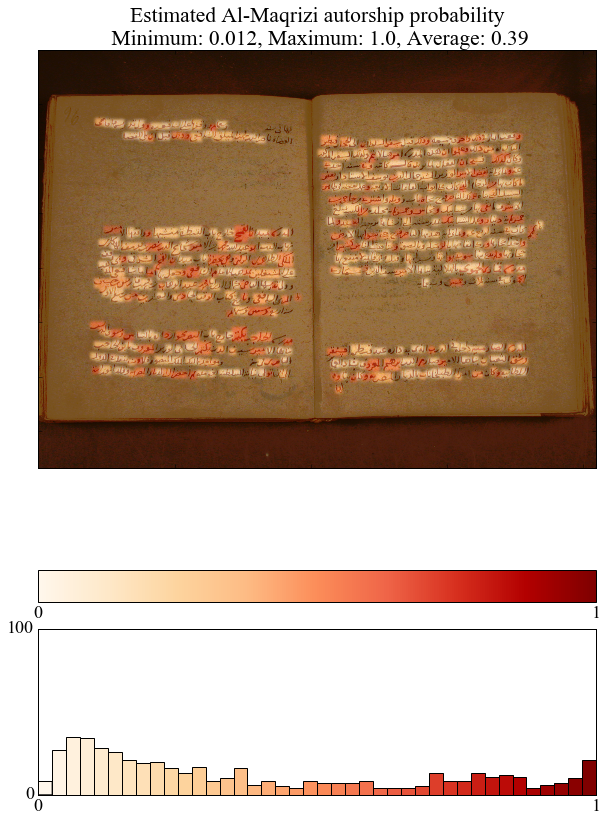

---------------------------------------------------------------------------------------------
Image file: "S Ali Pasa 1847 011.jpg"
extracted regions: 2761
filtered regions: 893


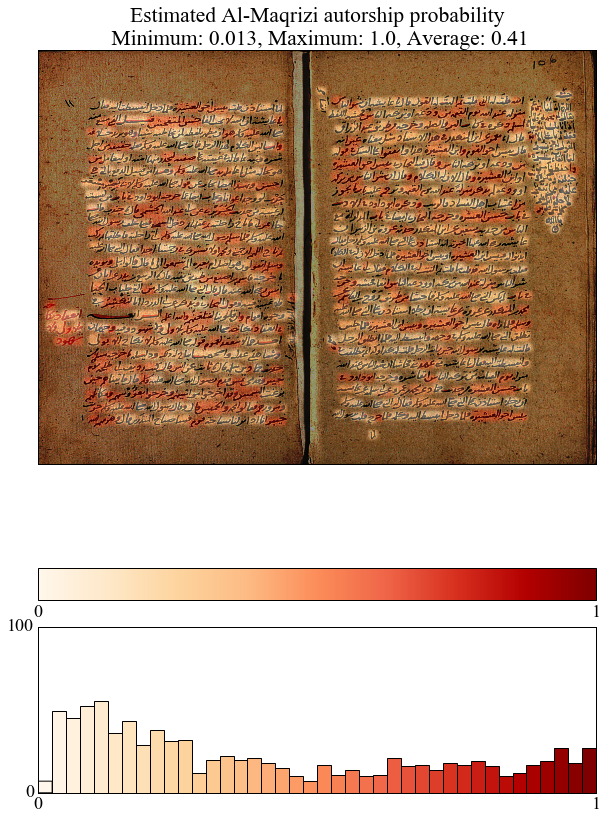

---------------------------------------------------------------------------------------------
Image file: "MURAD MOLLA     575-_00055.JPG"
extracted regions: 2871
filtered regions: 866


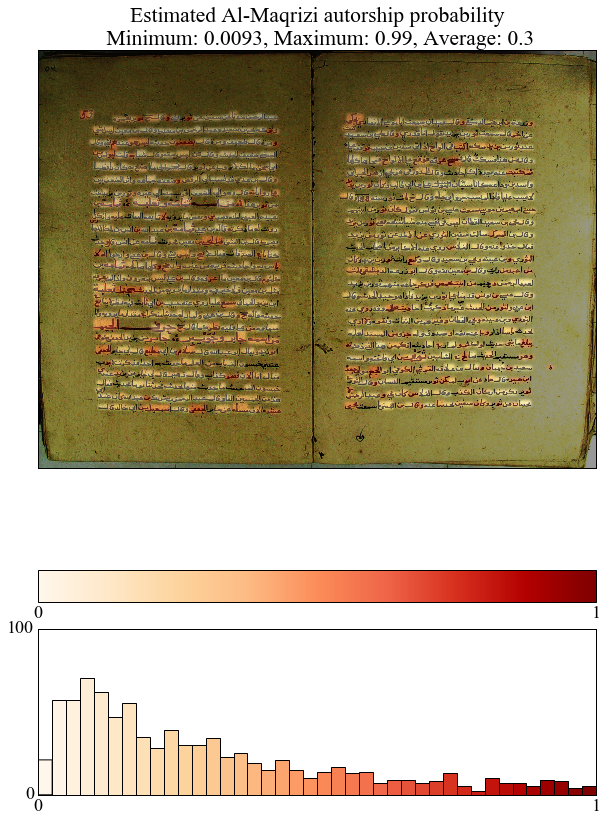

In [12]:
for image_file in [os.path.join(bauden_images_dir, f) for f in os.listdir(bauden_images_dir)]:
    process_image(image_file)